## Traditional CV basic operations

This notebook demonstrates some basic open cv operations by walking through a simple task of detecting the pupil(essentially, an ellipse) in an image taken under a microscope in a cataract surgery. 
The following contents are covered: 
### * [Read images](#read)
* cv.imread(), its confusing flag numbers and traps you should be aware of
* cv.cvtColor() and openCV's various color format

### * [Preprocessing]()
* threshold()
* blur(), erode, dilate() ...

### * [Killer methods]()
* findContours() and convexHull()
* fitEllipse()

In [12]:
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os
import random
#%matplotlib notebook

In [6]:
# Specify data path as step 0 for everything
image_dir = os.path.join(os.getcwd(), 'PupilData')
print(image_dir)
all_images = os.listdir(image_dir)
num_images = len(all_images)
print(num_images)

/Users/al/proj/studynotes/opencv_basics/PupilData
200


### <a id='read'>Read image from a file</a>
The main method you need to read from an image file is cv.imread(filename[, flags=cv.IMREAD_COLOR]). 

The IMREAD flag specifies the color space you'd like to read the image with. One should be familier with imread flag and its corresponding numbers if you don't wanna type the long flag name every single time. To know more about color space conventions, check out this 
[awesome article on most widely used color spaces](https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/). 

Flags in open cv can be confusing for beginners, as their corresponding number isn't necessarity align with the index number where they're defined. 
So, it will be helpful to have this note: 
![IMREAD FLAGS](flags.png)


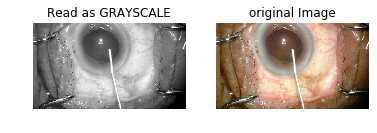

In [274]:
# Here I randomly picked one image from my dataset for demo
sample_image = os.path.join(image_dir, '123438-2.png')
# fig = plt.figure(figsize=(10, 10))
gray = cv2.imread(sample_image, cv.IMREAD_GRAYSCALE)
plt.subplot(121)
plt.title('Read as GRAYSCALE')
plt.axis('off')
# You should specify colormap used by matplotlib.pyplot
# with the cmap flag
plt.imshow(gray, cmap='gray')

img = cv2.imread(sample_image, cv.IMREAD_COLOR)
plt.subplot(122)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.title('original Image')
plt.axis('off')
plt.imshow(img)

# img = cv2.imread(sample_image, cv2.IMREAD_UNCHANGED)
# fig.add_subplot(3, 3, 1)
# plt.title('IMREAD_UNCHANGED')
# plt.axis('off')
# plt.imshow(img)
# img = cv2.imread(sample_image, cv.IMREAD_GRAYSCALE)
# ax=fig.add_subplot(3, 3, 2)
# ax.axis('off')
# plt.text(0.5, -0.1, 'IMREAD_GRAYSCALE', horizontalalignment='center', verticalalignment='center', \
#       transform=ax.transAxes)# another title layout trick..
# plt.imshow(img)

Notice that you would want to specify the colormap that Matplotlib.pyplot should use. It takes 'color' by default, and you will get this creepy result when trying to show a grayscale image.. 
![IMREAD FLAGS](green.png)
Checkout Matplotlib's [official colormap code](https://matplotlib.org/examples/color/colormaps_reference.html). 

Another consequence from this colorspace requirement is that you would have to convert what's read with openCV to RGB before asking matplotlib to display it.
Because, if you go with IMREAD_COLOR option, openCV will returns you a BGR image, which is essentially three matrices: B, G, R. However, if you ask matplotlib to show this by its default colorspace, which is 'color', it is actually using the RGB space. As a result, the matrix that represent blue channel will be taken as the read channel. Again, you'll get creepy result. 

### <a id='process'>Some basic preprocessing techniques</a>
#### threshold()
Threshholding is by all means the simplest segmentation method known. You just take a grayscale image, which essentially is a 2d array, and assign every pixel a true(within the range you set) or false(out of the range you set). This appraoch is very well documented so I'll just leave [a link](https://docs.opencv.org/2.4/doc/tutorials/imgproc/threshold/threshold.html) here.  

Optionally, you may also do this line: 
  pixel = pixel>(sometimes <)thres? defalt_val : pixel. 

Three things to keep in mind about this method: 
* It takes a grayscale image, i.e, one channel. 
* Go with the right flags..
    [Types of thresholding](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html). 
* Tune the thresdhold value if needed.

#### TODO: erode(), dilate(), blur, etc.. 

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


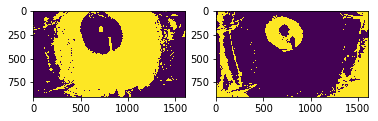

In [291]:
# A short demo of different thresholding approaches. 
# Check out documentation(link above) for a more comprehensive example. 
thresh0 = gray >= 120
plt.subplot(121)
plt.imshow(thresh0)
print(type(thresh0))
_, thresh1=cv.threshold(gray, thresh=90, maxval=255, type=1)
plt.subplot(122)
plt.imshow(thresh1)
print(type(thresh1))

#### <a id='killer'>Some killer methods</a>

With the thresholded image, we're ready to pick the pupil out of nosises. We will do this by first running findContours() method to get all contours, get the convex hull for each contour, then fit an ellipse, and filter out what's unrelevant. 

Brief intro to methods used: 
* findContours()
    It returns a list of list of points. 
    drawContours() method to draw a certain contour on a given imge.
    Checkout comments of the code in the following cell for an example of usage.

* convexHull()
    I thought of this method in writing up this example because it would be helpful to get rid of the effect of the surgery instrument that covers a portion of the pupil. This will make the ellipse we get a bit smaller that what it should be consider the LST algorithm used in fitting an ellipse from a collection of points. 
    The following screenshot is the best exaple to see what convexHull() method does: 
    ![hull](hull.png)

* fitEllipse() 
  This method finds an ellipse that best fits the given list of points, but note that it returns a tuple that represents a bounding box of the ellipse found. Attributes are: 
  (\[center coordinates\], \[Max axis, min axis\], angle).
  
  
#### Two naive appoaches are used to filter out noise ellipses. 
  * By size of the contour. See line 4. 
  * Bounding box info is used to calculate the eccentricity of the ellipse found to select the best fit of the pupil. 


### TODO: cv.connectedComponents(), HoughEdgeDetector()
...etc

7


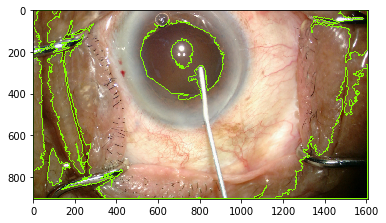

In [292]:
#
thresh = thresh1
contours, _ = cv2.findContours(image=thresh, mode=cv.RETR_LIST, method=cv.CHAIN_APPROX_SIMPLE)
# canvas = np.copy()
canvas=cv.imread(sample_image, cv.IMREAD_COLOR)
canvas=cv.cvtColor(canvas, cv.COLOR_BGR2RGB)
# canvas = np.zeros_like(thresh)
contours = [c for c in contours if len(c) > 200] 
print(len(contours))
cv.drawContours(canvas, contours, contourIdx=-1, color=(128, 250, 0), lineType=4, thickness=3)

plt.imshow(canvas)


((110.11832427978516, 754.81396484375), (99.14348602294922, 157.73489379882812), 4.533865451812744)
((151.07278442382812, 471.55078125), (96.4981460571289, 586.7660522460938), 167.50155639648438)
((716.0791625976562, 205.7620849609375), (99.48088836669922, 134.067138671875), 174.87210083007812)
((265.34197998046875, 29.65404510498047), (90.98632049560547, 261.8594055175781), 46.7963981628418)
((709.2489013671875, 225.685546875), (342.65478515625, 388.7690734863281), 106.1782455444336)
((1444.449462890625, 140.36712646484375), (215.29177856445312, 333.5867004394531), 77.18787384033203)
((796.8839111328125, 297.58441162109375), (1300.109375, 1546.2593994140625), 71.32292175292969)


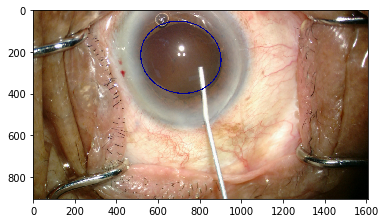

In [293]:
# Without using convex 
boxes = [cv.fitEllipse(cont) for cont in contours]
hull = [cv.convexHull(cont) for cont in contours]
boxes_hull = [cv.fitEllipse(_) for _ in hull if len(_) > 5]
ellipse_canvas=cv.imread(sample_image, cv.IMREAD_COLOR)
ellipse_canvas=cv.cvtColor(ellipse_canvas, cv.COLOR_BGR2RGB)
for _ in boxes:
#    print(_)
    if _[1][1] > 1.3 * _[1][0] or _[1][1] > 0.8 * gray.shape[0]:
        pass
    else:
        cv.ellipse(ellipse_canvas, _, (128, 255, 0), thickness=3)

for _ in boxes:
    print(_)
    if _[1][1] > 1.3 * _[1][0] or _[1][1] > 0.8 * gray.shape[0]:
        pass
    else:
        cv.ellipse(ellipse_canvas, _, (0, 0, 150), thickness=3)
    
# ellipse_canvas = cv.cvtColor(ellipse_canvas, cv.COLOR_BGR2RGB)
plt.imshow(ellipse_canvas)

Done! 
The result seems satisfying. However, remember that we hardcoded a threshold value. 
The question left is, is there a way to automatically set upo a good threshold?

To be continued.. 